Final Project (Churn Prediction)
Andrew Hua and 
1. Data Preprocessing

In [57]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
import warnings

In [58]:
# 1. EDA: Basic info and summary
print("Dataset Info:")
print(churn_data.info())
print("\nDataset Description:")
print(churn_data.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  float64
 4   Geography        10000 non-null  int64  
 5   Gender           10000 non-null  int64  
 6   Age              10000 non-null  float64
 7   Tenure           10000 non-null  float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(5), int64(8), object(1)
memory usage: 1.1+ MB
None

Dataset Description:
         RowNumber    CustomerId   CreditScore     Ge

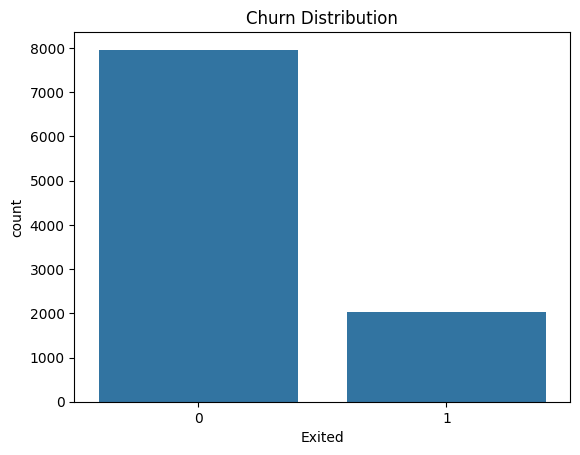


Missing Values:
RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


In [59]:
# Visualize target variable distribution
sns.countplot(data=churn_data, x='Exited')
plt.title('Churn Distribution')
plt.show()
# Check for missing values
print("\nMissing Values:")
print(churn_data.isnull().sum())

In [60]:
# Handle Outliers by using IQR
numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
for col in numerical_features:
    Q1 = churn_data[col].quantile(0.25)
    Q3 = churn_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = churn_data[(churn_data[col] < lower_bound) | (churn_data[col] > upper_bound)]
    print(f"Outliers in {col}: {len(outliers)}")



Outliers in CreditScore: 15
Outliers in Age: 359
Outliers in Tenure: 0
Outliers in Balance: 0
Outliers in EstimatedSalary: 0



Class Weights:
{0: np.float64(0.6279434850863422), 1: np.float64(2.4539877300613497)}

Final Dataset Shapes:
X_train: (8000, 10), y_train: (8000,)
X_test: (2000, 10), y_test: (2000,)


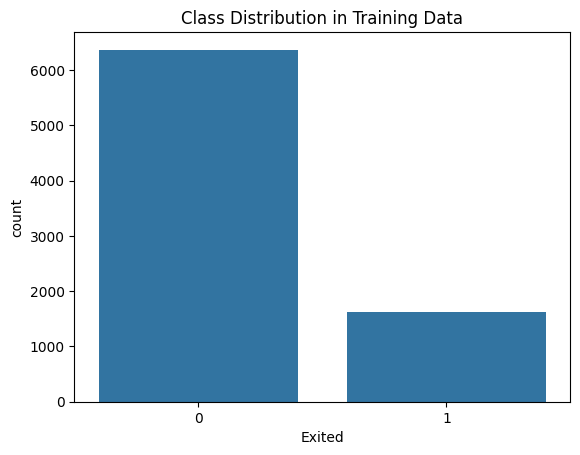

In [61]:
#Encode Categorical Variables
categorical_features = ['Geography', 'Gender']
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    churn_data[col] = le.fit_transform(churn_data[col])
    label_encoders[col] = le
    
#Normalize Numerical Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
churn_data[numerical_features] = scaler.fit_transform(churn_data[numerical_features])

#Split Dataset into Train and Test Sets
X = churn_data.drop(columns=['Exited', 'RowNumber', 'CustomerId', 'Surname'])
y = churn_data['Exited']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

#Compute Class weights
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print("\nClass Weights:")
print(class_weight_dict)

# Final Dataset Shapes
print("\nFinal Dataset Shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

# Visualize Class Distribution
sns.countplot(x=y_train)
plt.title('Class Distribution in Training Data')
plt.show()


In [62]:
# Function to Train and Evaluate Models
def train_and_evaluate(model, model_name):
    print(f"\nTraining {model_name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {accuracy:.2f}")
    return accuracy

# Model Implementations
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Support Vector Machine (SVM)": SVC(kernel='linear', random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42),
    "Naïve Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=100),
    "XGBoost": XGBClassifier(random_state=42, eval_metric='logloss'),
    "Deep Learning (MLP)": MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
}

# Train and Evaluate Each Model
results = {}
for model_name, model in models.items():
    results[model_name] = train_and_evaluate(model, model_name)

# Summary of Results
print("\nModel Performance Summary:")
for model_name, accuracy in results.items():
    print(f"{model_name}: Accuracy = {accuracy:.2f}")


Training Decision Tree...

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      1593
           1       0.45      0.48      0.47       407

    accuracy                           0.78      2000
   macro avg       0.66      0.67      0.66      2000
weighted avg       0.78      0.78      0.78      2000

Decision Tree Accuracy: 0.78

Training Support Vector Machine (SVM)...

Support Vector Machine (SVM) Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1593
           1       0.00      0.00      0.00       407

    accuracy                           0.80      2000
   macro avg       0.40      0.50      0.44      2000
weighted avg       0.63      0.80      0.71      2000

Support Vector Machine (SVM) Accuracy: 0.80

Training Logistic Regression...

Logistic Regression Classification Report:
              precision    recall  f